In [5]:
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sc
import statistics as stats
import concurrent.futures as fu
import collections

def image_processing(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kernel = np.ones((5,5),np.uint8)
    img = cv.GaussianBlur(img, (5,5),cv.BORDER_DEFAULT)
    img = cv.fastNlMeansDenoising(img, None, 10, 7, 21 )
    # opening = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)  
    img = cv.dilate(img,kernel,iterations = 1)
    return cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 5, 2)

def findContour(image):
    contours, hierarchy = cv.findContours(image, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    listOfRect = printExternalContour(image, contours, hierarchy)
    for rect in listOfRect:
        cv.rectangle(image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (121, 11, 189), 2)

    return listOfRect, image


def printExternalContour(img, contours, hierarchy):
    listOfHierarchy = hierarchy[0]
    listOfRect, listOfLevel, listOfContours, done = ([] for i in range(4))
    currLv = 0

    for hierarchY in listOfHierarchy:
        listOfLevel.append(0)
        done.append(0)

    for i in range(len(listOfHierarchy)):
        if done[i] == 0:
            done[i] = 1
            next = listOfHierarchy[i][0]
            while next != -1:
                done[next] = 1
                listOfLevel[next] = currLv
                next = listOfHierarchy[next][0]
            currLv+=1

    for i in range(len(listOfHierarchy)):
        if listOfLevel[i] %2 == 0:
            listOfContours.append(contours[i])
        
    contours_poly = [None]*len(listOfContours)

    for i, c in enumerate(listOfContours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        tmp = cv.boundingRect(contours_poly[i])
        if tmp[2]*tmp[3] < 6000 and tmp[2]*tmp[3] > 100:
            listOfRect.append(cv.boundingRect(contours_poly[i]))
    # print(listOfLevel)
    return listOfRect

# input: histogram, max index, cl
# output: is a line?

def projection_hist(img, choice, density):
    # img = cv.imread(filename)   
    img = cv.bitwise_not(img)
    # cv.imshow("Frame", img)
    # cv.waitKey(0)  

    img_row_sum = np.sum(img,axis=choice)
    img_row_sum_arr = np.asarray(img_row_sum)

    c_max_index = sc.argrelextrema(img_row_sum_arr, np.greater, order=density)
    c_min_index = sc.argrelextrema(img_row_sum_arr, np.less, order=density)

    return img_row_sum, c_min_index[0], c_max_index[0]

def is_a_line(hist, max_index, ch, ca, cl): 
    if hist[max_index] > 1.3*ch:
        return True
    if hist[max_index] < cl:
        return False
    number_of_max = 0
    forward = max_index+2
    backward = max_index
    
    curr = max_index+1
    while hist[curr] > cl:
        if forward > len(hist)-1 or curr > len(hist)-1 or backward <0:
            break
        if hist[forward] < hist[curr] and hist[backward] < hist[curr]:
            number_of_max +=1
        backward = curr
        curr = forward
        forward+=1
    
    forward = max_index
    curr = max_index - 1
    backward = max_index -2

    while hist[curr] > cl:
        if forward > len(hist)-1 or curr > len(hist)-1 or backward <0:
            break
        if hist[forward] < hist[curr] and hist[backward] < hist[curr]:
            number_of_max +=1
        forward = curr
        curr = backward
        backward-=1

    if number_of_max>2:
        return False
    return True

def line_detection(img, choice):
    img_sum, min_index, max_index = projection_hist(img, choice, 10)
    img_sum_arr = np.asarray(img_sum)
    
    ch, ca, cl = c_calculator(img_sum_arr, min_index, max_index)
    
    # Draw the graphs using matplotlib
    plt.plot(img_sum)
    plt.scatter(max_index, img_sum_arr[max_index],linewidth=0.3, s=30, c='r')
    plt.scatter(min_index, img_sum_arr[min_index],linewidth=0.3, s=30, c='b')
    plt.axhline(y=ch, color='r', linestyle='-')
    plt.axhline(y=cl, color='g', linestyle='-')
    plt.axhline(y=ca, color='b', linestyle='-')
    plt.show()

    isa_line = []
    isa_line_location =[]
    for idx in max_index:
        isa_line.append(is_a_line(img_sum, idx, ch, ca, cl))
    for i in range(len(isa_line)):
        if isa_line[i] is True:
            isa_line_location.append(max_index[i])
    print(isa_line)
    return isa_line_location

def c_calculator(img_sum_arr, min_index, max_index):
    min_value = img_sum_arr[min_index].tolist()
    max_value = img_sum_arr[max_index].tolist()

    ca = int(np.mean(img_sum_arr))
    min_value.append(ca)
    min_value.append(int(sorted(img_sum_arr).pop(0)))
    max_value.append(ca)
    max_value.append(int(sorted(img_sum_arr).pop()))
    ch = stats.mean(max_value)
    cl = stats.mean(min_value)

    return ch, ca, cl

def choose_subimage(cropped, cropped_coordinate):
    satisfiedImgs, satisfiedImgsCor = ([] for i in range(2))
    for i in range(len(cropped)):
        cv.imshow("Frame", cropped[i])
        cv.waitKey(0)

        img_column_sum, _, max_col_index = projection_hist(image_processing(cropped[i]), 0, 2)
        img_row_sum, _, max_row_index = projection_hist(image_processing(cropped[i]), 1, 2)
        img_column_sum_arr = np.asarray(img_column_sum)
        img_row_sum_arr = np.asarray(img_row_sum)

        mean_max_col = np.mean(img_column_sum_arr[max_col_index])
        mean_max_row = np.mean(img_row_sum_arr[max_row_index])

        # plt.plot(img_column_sum)
        # plt.scatter(max_col_index, img_column_sum_arr[max_col_index],linewidth=0.3, s=30, c='r')
        # # plt.scatter(min_col_index, img_column_sum_arr[min_col_index],linewidth=0.3, s=30, c='b')
        # plt.axhline(y=ch_v, color='r', linestyle='-')
        # plt.axhline(y=cl_v, color='g', linestyle='-')
        # plt.axhline(y=ca_v, color='b', linestyle='-')
        # plt.axhline(y=mean_max_col, color='y', linestyle='-')
        # plt.show()

        plt.plot(img_row_sum)
        plt.scatter(max_row_index, img_row_sum_arr[max_row_index],linewidth=0.3, s=30, c='r')
        # plt.scatter(min_row_index, img_row_sum_arr[min_row_index],linewidth=0.3, s=30, c='b')
        plt.axhline(y=ch_h, color='r', linestyle='-')
        plt.axhline(y=cl_h, color='g', linestyle='-')
        plt.axhline(y=ca_h, color='b', linestyle='-')
        plt.axhline(y=mean_max_row, color='y', linestyle='-')
        plt.show()

        # if len(max_col_index) > 10 or len(max_row_index) > 10:
        #     satisfiedImgs.append(cropped[i])
        #     satisfiedImgsCor.append(cropped_coordinate[i])
        #     print('appended')

        # max_col_value = img_column_sum_arr[max_col_index].tolist()
        # max_row_value = img_row_sum_arr[max_row_index].tolist()

        # for max in max_col_value:
        #     if max > cl_v:
        #         count +=1 
        
        # print(count)

        if mean_max_col > cl_v and mean_max_row > cl_h and mean_max_col != None and mean_max_row != None:
            satisfiedImgs.append(cropped[i])
            satisfiedImgsCor.append(cropped_coordinate[i])
            print('appended')

    for img in satisfiedImgs:
        cv.imshow("Frame", img)
        cv.waitKey(0)
    print(satisfiedImgsCor)
    
    return satisfiedImgs, satisfiedImgsCor

def projection_cut(satisfiedImgs, satisfiedImgsCor):
    characters = []
    characterCoordinates = []
    cv.imshow("Frame", satisfiedImgs)
    cv.waitKey(0)

    img_column_sum, min_col_index, max_col_index = projection_hist(image_processing(satisfiedImgs), 0, 10)
    img_row_sum, min_row_index, max_row_index = projection_hist(image_processing(satisfiedImgs), 1, 10)
    img_column_sum_arr = np.asarray(img_column_sum)
    img_row_sum_arr = np.asarray(img_row_sum)

    ch_v, ca_v, cl_v = c_calculator(img_column_sum_arr, min_col_index, max_col_index)
    ch_h, ca_h, cl_h = c_calculator(img_row_sum_arr, min_row_index, max_row_index)

    plt.plot(img_column_sum)
    plt.scatter(max_col_index, img_column_sum_arr[max_col_index],linewidth=0.3, s=30, c='r')
    plt.scatter(min_col_index, img_column_sum_arr[min_col_index],linewidth=0.3, s=30, c='b')
    plt.axhline(y=ch_v, color='r', linestyle='-')
    plt.axhline(y=cl_v, color='g', linestyle='-')
    plt.axhline(y=ca_v, color='b', linestyle='-')
    plt.show()

    plt.plot(img_row_sum)
    plt.scatter(max_row_index, img_row_sum_arr[max_row_index],linewidth=0.3, s=30, c='r')
    plt.scatter(min_row_index, img_row_sum_arr[min_row_index],linewidth=0.3, s=30, c='b')
    plt.axhline(y=ch_h, color='r', linestyle='-')
    plt.axhline(y=cl_h, color='g', linestyle='-')
    plt.axhline(y=ca_h, color='b', linestyle='-')
    plt.show()

    promo_v = collections.defaultdict(lambda: 0)
    promo_h = collections.defaultdict(lambda: 0)
    
    for max in max_col_index:
        promo_v[character_coor_locating(img_column_sum, max, ch_v, ca_v, cl_v)] +=1
    for max in max_row_index:
        promo_h[character_coor_locating(img_row_sum, max, ch_h, ca_h, cl_h)] +=1
    
    promo_v = list(promo_v.keys())
    promo_h = list(promo_h.keys())

    for i in range(len(promo_v)-1, -1, -1):
        for promo2 in promo_h:
            if promo_v[i][0] != promo_v[i][1] and promo2[0] != promo2[1]: 
                characters.append(satisfiedImgs[promo2[0]:promo2[1], promo_v[i][0]:promo_v[i][1]])
                characterCoordinates.append((promo_v[i][0], promo2[0], promo_v[i][1], promo2[1]))

    # tmpImg = []
    # for promo in promo_v:
    #     if promo[0] != promo[1]:
    #         tmpImg.append(satisfiedImgs[0:int(satisfiedImgs.shape[0]), promo[0]:promo[1]])
    
    
    # for i in range(len(tmpImg)-1, -1, -1):
    #     cv.imshow("Frame", tmpImg[i])
    #     cv.waitKey(0)
    #     img_row_sum_min, min_row_index_mini, max_row_index_mini = projection_hist(image_processing(tmpImg[i]), 1, 10)
    #     img_row_sum_mini_arr = np.asarray(img_row_sum_min)
    #     ch_h_mini, ca_h_mini, cl_h_mini = c_calculator(img_row_sum_mini_arr, min_row_index_mini, max_row_index_mini)
        
    #     plt.plot(img_row_sum_min)
    #     plt.scatter(max_row_index_mini, img_row_sum_mini_arr[max_row_index_mini],linewidth=0.3, s=30, c='r')
    #     plt.scatter(min_row_index_mini, img_row_sum_mini_arr[min_row_index_mini],linewidth=0.3, s=30, c='b')
    #     plt.axhline(y=ch_h, color='r', linestyle='-')
    #     plt.axhline(y=cl_h, color='g', linestyle='-')
    #     plt.axhline(y=ca_h, color='b', linestyle='-')
    #     plt.show()

    #     promo_h = collections.defaultdict(lambda: 0)
    #     for max in max_row_index_mini:
    #         promo_h[character_coor_locating(img_row_sum_min, max, ch_h_mini, ca_h_mini, cl_h_mini)] +=1
    #     promo_h = list(promo_h.keys())

    #     for promo in promo_h:
    #         if promo[0] != promo[1]:
    #             characters.append(tmpImg[i][promo[0]:promo[1], 0:int(tmpImg[i].shape[1])])
    #     print(i)

    print(characterCoordinates)
    for img in characters:
        cv.imshow("Frame", img)
        cv.waitKey(0)

    return characters, characterCoordinates

def character_coor_locating(hist, max_index, ch, ca, cl):
    # plt.plot(hist)
    # plt.scatter(hist, hist[max_index],linewidth=0.3, s=30, c='r')
    # plt.axhline(y=ch, color='r', linestyle='-')
    # plt.axhline(y=cl, color='g', linestyle='-')
    # plt.axhline(y=ca, color='b', linestyle='-')
    # plt.show()
    begin = end = None
    curr = max_index
    while True:
        if curr > len(hist)-1:
            end = len(hist)
            break
        if hist[curr] <= cl:
            end = curr
            break
        curr += 1

    curr = max_index 

    while True:
        if curr <0:
            begin = 0
            break
        if hist[curr] <= cl:
            begin = curr
            break
        curr -= 1
    return (begin, end)

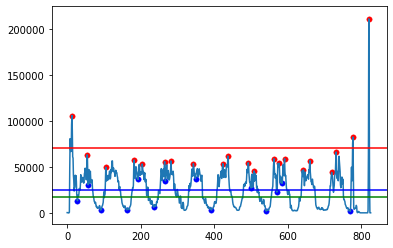

[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True]


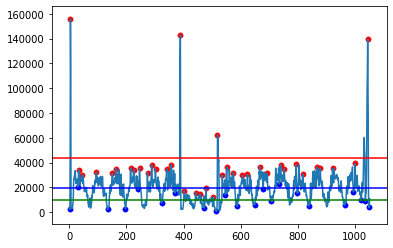

[True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True]


In [7]:
#unit test
filename = "D:/NLP dataset/page002.jpg"
# filename = './dv001.jpg'
img = cv.imread(filename)

cv.imshow("Frame", img)
cv.waitKey(0)

scale_percent = 150 #225# percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
raw = cv.resize(img, dim, interpolation = cv.INTER_AREA)

cv.imshow("Frame", img)
cv.waitKey(0)
img = image_processing(raw)


# cv.imshow("Frame", img)
# cv.waitKey(0)  

# _, image = findContour(img)    
     
# cv.imshow("Frame", image)
# cv.waitKey(0)   

#horizontal: 1; vertical: 0
img_column_sum, min_column_idx, max_column_idx = projection_hist(img, 0, 10)
img_row_sum, min_row_idx, max_row_idx = projection_hist(img, 1, 10)

ch_v, ca_v, cl_v = c_calculator(img_column_sum, min_column_idx, max_column_idx)
ch_h, ca_h, cl_h = c_calculator(img_row_sum, min_row_idx, max_row_idx)
vertical_line = line_detection(img, 0)
horizontal_line = line_detection(img, 1)

vertical_line.insert(0,0)
vertical_line.append(int(img.shape[1]))
horizontal_line.insert(0,0)
horizontal_line.append(int(img.shape[0]))

print(vertical_line, horizontal_line)
    
cropped = []
cropped_coordinate =[]
for i in range(len(vertical_line)-1):
    for j in range(len(horizontal_line)-1):
        cropped.append(raw[horizontal_line[j]:horizontal_line[j+1], vertical_line[i]:vertical_line[i+1]])
        cropped_coordinate.append((horizontal_line[j], vertical_line[i], horizontal_line[j+1], vertical_line[i+1]))

print(cropped_coordinate)
    
satisfiedImgs, satisfiedImgsCor = choose_subimage(cropped, cropped_coordinate)

for image in satisfiedImgs:
    cv.imshow("Frame", image)
    cv.waitKey(0)
print(satisfiedImgsCor)

for i in range(len(satisfiedImgs)):
    projection_cut(satisfiedImgs[i], satisfiedImgsCor[i])